In [23]:
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import shutil
import copy
import glob
import tqdm
import random
import pickle
from collections import defaultdict
import requests
import PIL


import sklearn
import sklearn.svm
import sklearn.model_selection
from sklearn.model_selection import train_test_split



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline
%load_ext autoreload
%autoreload 2

PyTorch Version:  1.7.1+cpu
Torchvision Version:  0.8.2+cpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Different Models and Layers

In [2]:
batch_size = 8
num_epochs = 5
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes=1000, feature_extract=True, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [3]:
densenet, input_size = initialize_model("densenet")
densenet.eval()

densenet_bottom = copy.deepcopy(densenet)
densenet_top = densenet.classifier

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(self, x):
        return x
    
densenet_bottom.classifier = Identity()

In [4]:
squeezenet, input_size = initialize_model("squeezenet")
squeezenet.eval()

squeezenet_bottom_ = copy.deepcopy(squeezenet)
squeezenet_top = squeezenet.classifier

squeezenet_bottom_.classifier = Identity()
    
def squeezenet_bottom(t):
    return squeezenet_bottom_(t).view((-1, 512, 13, 13))

In [5]:
resnet, input_size = initialize_model("resnet")
resnet.eval()

resnet_bottom = copy.deepcopy(resnet)
resnet_top = resnet.fc

resnet_bottom.fc = Identity()

In [6]:
vggnet, input_size = initialize_model("vgg")
vggnet.eval()

vggnet_bottom = copy.deepcopy(vggnet)
vggnet_top = vggnet.classifier

vggnet_bottom.classifier = Identity()

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\lion.jpg").convert("RGB")
tensor = data_transforms["val"](img).unsqueeze(0)

In [9]:
print(np.allclose(densenet(tensor), densenet_top(densenet_bottom(tensor))))
print(np.allclose(resnet(tensor), resnet_top(resnet_bottom(tensor))))
print(np.allclose(vggnet(tensor), vggnet_top(vggnet_bottom(tensor))))
print(np.allclose(squeezenet(tensor).squeeze(), squeezenet_top(squeezenet_bottom(tensor)).squeeze()))

True
True
True
True


# Layer Accuracies

In [230]:
dense_concept_dict = copy.deepcopy(concept_dict)

In [25]:
models = [squeezenet, densenet, resnet, vggnet]
tops = [squeezenet_top, densenet_top, resnet_top, vggnet_top]
bottoms = [squeezenet_bottom, densenet_bottom, resnet_bottom, vggnet_bottom]
names = ['sq', 'densenet', 'resnet', 'vgg']
num = 3


concepts = ['bed', 'stripes', 'dog', 'flag', 'cow']
scores = []

for model, top, bottom, name in zip(models[:num], tops[:num], bottoms[:num], names[:num]):
    concept_dict = pickle.load(open('{}_concepts_170.pkl'.format(name), 'rb'))
    score = [concept_dict[c][2] for c in concepts]
    scores.append(score)
    
concept_scores = {str(name):scores[n] for n, name in enumerate(names[:num])}

(array([0.15, 1.15, 2.15, 3.15, 4.15]),
 [Text(0, 0.15, 'bed'),
  Text(0, 1.15, 'stripes'),
  Text(0, 2.15, 'dog'),
  Text(0, 3.15, 'flag'),
  Text(0, 4.15, 'cow')])

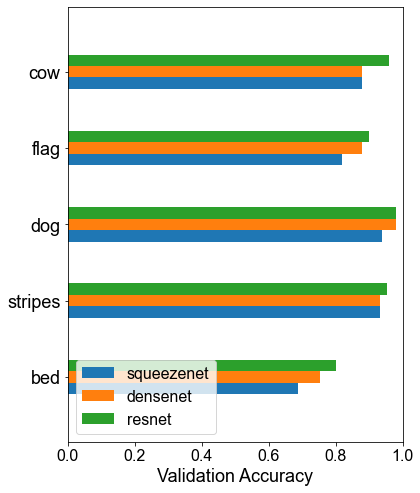

In [35]:
import pandas
import matplotlib.pyplot as plt
import numpy as np

df = pandas.DataFrame(dict(graph=concepts, **concept_scores)) 

ind = np.arange(len(df))
width = 0.15

fig, ax = plt.subplots(figsize=[6, 8])
for n, name in enumerate(names[:num]):
    ax.barh(ind + n*width, df[name], width, label=name.replace("sq", "squeezenet"))

ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend(prop={'family':'Arial', 'size':16}, loc="lower left")
ax.set_xlim([0.0, 1])

plt.xticks(fontname='Arial', fontsize=16)
plt.xlabel('Validation Accuracy', fontname='Arial', fontsize=18)
plt.yticks(fontname='Arial', fontsize=18)

# Evaluation Methods

In [32]:
response = requests.get("https://git.io/JJkYN")
class_labels = response.text.split("\n")

In [54]:
def get_concept_scores(tensor, label, bottom, top):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = bottom(tensor)
    original_preds = top(embedding).detach().numpy().squeeze()
    
    multiplier = 100000
    
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        shape = embedding.detach().numpy().shape
        plus = torch.from_numpy(embedding.detach().numpy().reshape(1, -1) + multiplier*coef).float()
        plus = plus.reshape(shape)
        plus_preds = top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
        
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [39]:
img = PIL.Image.open("C:\\Users\\islam\\downloads\\zebra-fig1a.jpg").convert("RGB")
tensor = data_transforms['val'](img).unsqueeze(0)

In [63]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra', squeezenet_bottom, squeezenet_top)

concept_dict = pickle.load(open('resnet_concepts_170.pkl', 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra', resnet_bottom, resnet_top)

In [64]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.5335502137043524


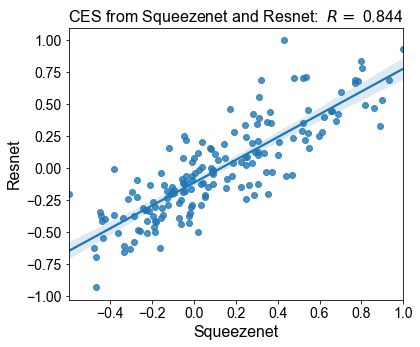

In [67]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Squeezenet and Resnet:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Squeezenet', fontname='Arial', fontsize=16)
plt.ylabel('Resnet', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [436]:
concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(10), 'rb'))
_, scores1, _ = get_concept_scores(tensor, 'zebra')

concept_dict = pickle.load(open('sq_layer_{}_concepts_170.pkl'.format(0), 'rb'))
_, scores2, _ = get_concept_scores(tensor, 'zebra')

In [437]:
l1 = []
l2 = []

for c in scores1:
    l1.append(scores1[c])
    l2.append(scores2[c])    
    
from sklearn.metrics import r2_score
l1 = np.array(l1)
l1 = l1 / np.max(np.abs(l1))
l2 = np.array(l2)
l2 = l2 / np.max(np.abs(l2))
print(r2_score(l1, l2))

0.6414172745652935


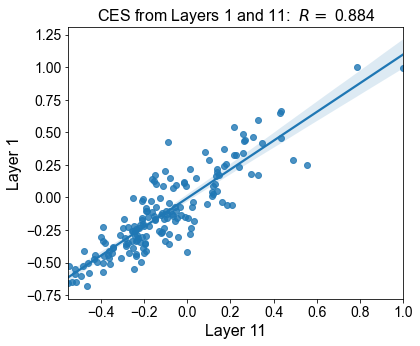

In [438]:
import seaborn as sns

plt.figure(figsize=[6, 5])
sns.regplot(x=l1, y=l2)
# plt.plot(l1, l2, '.')
plt.title('CES from Layers 1 and 11:  $R=$ ' + str(round(pearsonr(l1, l2)[0], 3)), fontname='Arial', fontsize=16)
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Layer 11', fontname='Arial', fontsize=16)
plt.ylabel('Layer 1', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);

In [372]:
concept_dict = pickle.load(open('sq_concepts_170.pkl', 'rb'))

In [388]:
def get_concept_scores_with_delta(tensor, label, multiplier):
    correct_idx = class_labels.index(label)
    concept_scores = {}
    embedding = model_bottom(tensor)
    original_preds = model_top(embedding).detach().numpy().squeeze()
        
    for key in concept_dict:
        coef, _, _ = concept_dict[key]
        plus = torch.from_numpy(embedding.detach().numpy() + multiplier*coef).float()
        plus_preds = model_top(plus)
        plus_diff = plus_preds.squeeze()[correct_idx] - original_preds.squeeze()[correct_idx]
        concept_scores[key] = float(plus_diff)
    
    m = np.max(np.abs(list(concept_scores.values())))
    for c in concept_scores:
        concept_scores[c] = concept_scores[c] / m
    
    concept_scores_list = sorted(concept_scores, key=concept_scores.get, reverse=True)    
    return original_preds[correct_idx], concept_scores, concept_scores_list    

In [422]:
all_scores = []
deltas = [1, 10, 100, 1000, 10000, 100000]

for delta in deltas:
    _, scores, lst = get_concept_scores_with_delta(tensor, 'zebra', delta)
    all_scores.append(scores)

In [423]:
top_concepts = lst[:5]

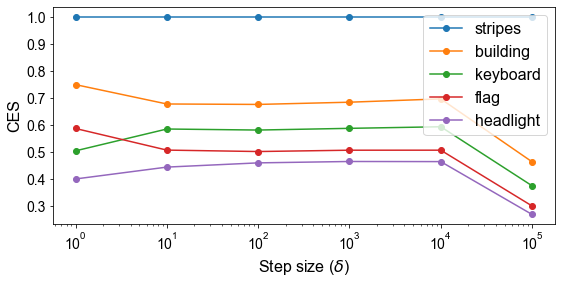

In [441]:
plt.figure(figsize=[9, 4])
for c in top_concepts:
    if c=="stripes":
        plt.semilogx(deltas, [1 for i in range(len(all_scores))], '-o', label=c)
    else:
        plt.semilogx(deltas, [all_scores[i][c] for i in range(len(all_scores))], '-o', label=c)
    
plt.legend(prop={'family':'Arial', 'size':16})
plt.xticks(fontname='Arial', fontsize=14)
plt.xlabel('Step size ($\delta$)', fontname='Arial', fontsize=16)
plt.ylabel('CES', fontname='Arial', fontsize=16)
plt.yticks(fontname='Arial', fontsize=14);